In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bats
import time
import hera_tda as hera

In [2]:
def barcodes_identical(ps0, ps1):
    ident = True
    for p, q in zip(ps0, ps1):
        ident = ident and\
        p.dim() == q.dim() and\
        p.birth() == q.birth() and\
        p.death() == q.death() and\
        p.birth_ind() == q.birth_ind() and\
        p.death_ind() == q.death_ind()
        
    return ident

def bottleneck_max(ps0, ps1, dmax=1):
    dist = 0
    for dim in range(dmax+1):
        ps0a = [p for p in ps0 if p.dim() == dim and p.length() > 0]
        ps1a = [p for p in ps1 if p.dim() == dim and p.length() > 0]
        dist += hera.BottleneckDistance(ps0a, ps1a)[0]
        
    return dist


def normalized_kt(U, X):
    """
    Compute normalized kendall-tau distance given update information U and starting filtration X
    """
    k = 0
    maxk = 0
    for d in range(X.maxdim() + 1):
        nd = X.ncells(d)
        maxk += (nd * (nd - 1)) // 2
        k += U.kendall_tau_dists[d]
        
    return k / maxk

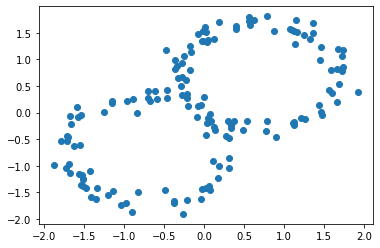

In [3]:
def gen_fig_8(n, r=1.0, sigma=0.1):
    X = np.random.randn(n,2)
    X = r * X / np.linalg.norm(X, axis=1).reshape(-1,1)
    X += sigma*np.random.randn(n, 2) + np.random.choice([-1/np.sqrt(2),1/np.sqrt(2)], size=(n,1))
    return X

np.random.seed(0)
n = 150
X = gen_fig_8(n)
noise = np.random.normal(size=X.shape)

plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
# build filtration
r = np.inf
Y = X + 0.1*noise
t0 = time.monotonic()
R0 = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(X)), bats.Euclidean(), r, 2)
t1 = time.monotonic()
print(t1 - t0)

t0 = time.monotonic()
R1 = bats.LightRipsFiltration(bats.DataSet(bats.Matrix(Y)), bats.Euclidean(), r, 2)
t1 = time.monotonic()
print(t1 - t0)

0.20725138194393367
0.20228998200036585


In [5]:
degree = -1
t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R0: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R1: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print("find UpdatInfo: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
RC0.update(U)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

print("bottleneck dist =", bottleneck_max(ps0, ps1))

R0: 2.11 sec.
R1: 2.24 sec.
find UpdatInfo: 0.15 sec.
update: 0.36 sec.
bottleneck dist = 0.0


In [6]:
degree = +1
t0 = time.monotonic()
DG0 = bats.FilteredF2DGVectorSpace(R0, degree)
RC0 = bats.ReducedFilteredF2DGVectorSpace(DG0, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R0: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
DG1 = bats.FilteredF2DGVectorSpace(R1, degree)
RC1 = bats.ReducedFilteredF2DGVectorSpace(DG1, bats.standard_reduction_flag(), bats.clearing_flag(), bats.compute_basis_flag())
t1 = time.monotonic()
print("R1: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
U = bats.UpdateInfo2(R0, R1)
t1 = time.monotonic()
print("find UpdatInfo: {:.2f} sec.".format(t1 - t0))

t0 = time.monotonic()
RC0.update(U)
t1 = time.monotonic()
print("update: {:.2f} sec.".format(t1 - t0))

ps0 = RC0.persistence_pairs(0) + RC0.persistence_pairs(1)
ps1 = RC1.persistence_pairs(0) + RC1.persistence_pairs(1)

print("bottleneck dist =", bottleneck_max(ps0, ps1))

R0: 0.54 sec.
R1: 0.50 sec.
find UpdatInfo: 0.15 sec.
update: 0.67 sec.
bottleneck dist = 0.0


Cohomology+clearing works very well on full Rips filtration (inf radius) as claimed in papers. However update on cohomology is twice slower.

In [7]:
def find_kt(U):
    kts = []
    for p in U.perm:
        kts.append(bats.kendall_tau(p))
    return kts

In [8]:
find_kt(U)

[0, 2974578, 7979125018]